In [110]:
## Data Processing
import pandas as pd
import numpy as np
import ast
## Plotting
import seaborn as sns
import matplotlib.pyplot as plt
## SVM Model
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, cross_validate
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.inspection import permutation_importance
from sklearn.metrics import ( accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, balanced_accuracy_score, roc_auc_score, precision_recall_curve)
from sklearn.preprocessing import label_binarize
from sklearn.base import clone

In [111]:
pd.set_option('display.max_columns', None)

In [112]:
df = pd.read_csv('combined_accidents_clean.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   publish_date                232 non-null    object 
 1   content                     232 non-null    object 
 2   time_24h                    232 non-null    object 
 3   corrected_date              232 non-null    object 
 4   injury_severity             232 non-null    object 
 5   affected_party              232 non-null    object 
 6   primary_accident_type_code  232 non-null    object 
 7   age                         232 non-null    object 
 8   ages_after_driven_by        232 non-null    object 
 9   driver_age_min              232 non-null    float64
 10  location                    229 non-null    object 
 11  street                      229 non-null    object 
 12  locality                    160 non-null    object 
 13  day_of_week_num             232 non

In [113]:
df.isnull().sum()
#location, street and locality have missing values, but it will not be used for predictions. Other columns have no missing values

publish_date                   0
content                        0
time_24h                       0
corrected_date                 0
injury_severity                0
affected_party                 0
primary_accident_type_code     0
age                            0
ages_after_driven_by           0
driver_age_min                 0
location                       3
street                         3
locality                      72
day_of_week_num                0
rush_hour                      0
rain_today                     0
rain_last_3h                   0
roadworks_nearby               0
vehicle_type_score             0
age_min_encoded                0
age_list                       0
time_period                    0
dtype: int64

<Axes: ylabel='count'>

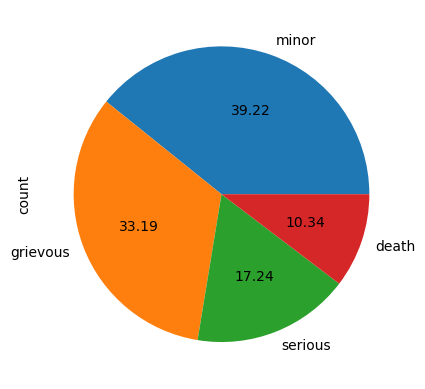

In [114]:
df['injury_severity'].value_counts().plot.pie(autopct='%.2f')

<Axes: ylabel='count'>

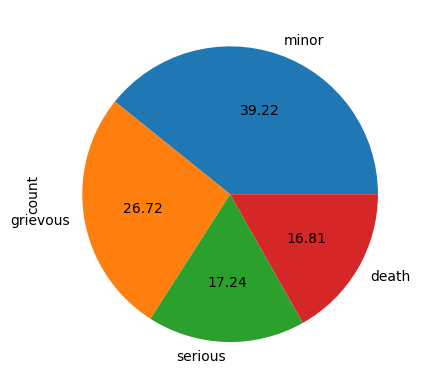

In [115]:
df = pd.read_csv('combined_accidents_balanced.csv')
df['injury_severity'].value_counts().plot.pie(autopct='%.2f')

In [116]:
# ===============================
# Time processing
# ===============================
# Convert the 'time_24h' column from string format (HH:MM) to datetime
# and extract only the hour component (0–23).
# This converts time into a numerical feature usable by the SVM model.
df["time_24h"] = pd.to_datetime(
    df["time_24h"], format="%H:%M", errors="coerce"
).dt.hour
# Time in 24 hours is split into time-of-day categories.
# This reduces noise and captures meaningful temporal patterns
# (e.g. rush hours vs night-time accidents).
df["time_period"] = pd.cut(
    df["time_24h"],
    bins=[0, 6, 12, 17, 24],
    labels=["Night", "Morning", "Afternoon", "Evening"],
    right=False
)

# ===============================
# Vehicle type score (from affected_party)
# ===============================
# Map the affected party to an ordinal severity-related score.
# Higher values represent heavier or more vulnerable road users.
# This creates a compact numerical representation suitable for SVM.
vehicle_score_map = {
    "pedestrian": 0,
    "cyclist": 1,
    "motorcyclist": 2,
    "car_driver": 2,
    "car_passenger": 2,
    "bus_driver": 4,
    "truck_driver": 4
}
# Apply the mapping to create a new numeric feature.
# Missing or unknown categories are assigned a default value of 0.
df["vehicle_type_score"] = (
    df["affected_party"]
    .map(vehicle_score_map)
    .fillna(0)
)

# ===============================
# Injury severity label consolidation
# ===============================
df["injury_severity"] = df["injury_severity"].replace(
    {
        "no injuries": "minor",
        "critical": "death",
        "grievous": "severe",
        "serious": "severe"
    }
)
## Extracts the minimum age from a value that may be:
##    - a string representation of a list (e.g. "['60','48']")
##    - a list of ages
##    - a single numeric value
##    The minimum age is used to represent the most vulnerable individual.
def extract_min_age(value):
    try:
        if isinstance(value, str):
            value = ast.literal_eval(value)  # converts "['60','48']" to [60,48]
        if isinstance(value, list) and len(value) > 0:
            return float(min(map(float, value)))  # take minimum age
        if isinstance(value, (int, float)):
            return float(value)
        return np.nan
    except (ValueError, SyntaxError):
        return np.nan

df["age"] = df["age"].apply(extract_min_age)
df["driver_age_min"] = df["driver_age_min"].apply(extract_min_age)

injury_severity
severe    102
minor      91
death      39
Name: count, dtype: int64


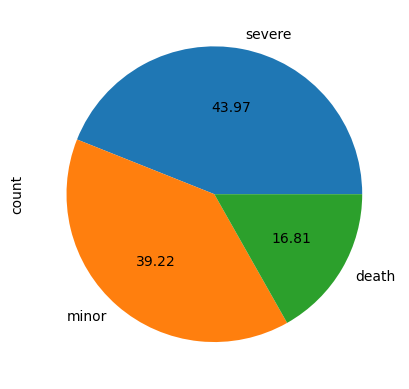

In [117]:
df['injury_severity'].value_counts().plot.pie(autopct='%.2f')
print(df['injury_severity'].value_counts())

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 232 entries, 0 to 231
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   publish_date                232 non-null    object  
 1   content                     232 non-null    object  
 2   time_24h                    232 non-null    int32   
 3   corrected_date              232 non-null    object  
 4   injury_severity             232 non-null    object  
 5   affected_party              232 non-null    object  
 6   primary_accident_type_code  232 non-null    object  
 7   age                         231 non-null    float64 
 8   ages_after_driven_by        232 non-null    object  
 9   driver_age_min              232 non-null    float64 
 10  location                    229 non-null    object  
 11  street                      229 non-null    object  
 12  locality                    160 non-null    object  
 13  day_of_week_num     

In [119]:
# Numerical features: continuous or ordinal values that can be directly scaled
numeric_features = ["age", "driver_age_min", "vehicle_type_score", "time_24h"]
# Categorical features: nominal or binary variables that require encoding
categorical_features = [
    "time_period", "primary_accident_type_code", "day_of_week_num", 
    "rush_hour", "rain_today", "rain_last_3h", "roadworks_nearby",
    "affected_party", "street", "locality"
]
# Ensure all categorical features are treated as strings (important for correct one-hot encoding)
for col in categorical_features:
    df[col] = df[col].astype(str)
# Separate predictors (X) and target variable (y)
# Non-informative text/date columns are excluded from the feature set
X = df.drop(columns=["injury_severity", "publish_date", "content", "corrected_date"])
y = df["injury_severity"]

# First split: Train+Val vs Test (80% / 20%)
# Stratification is used to preserve class distribution across splits,
# which is critical for imbalanced injury severity classes
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Second split: Train vs Validation (75% / 25% of remaining → 60/20 overall)
# The validation set is used for hyperparameter tuning,
# while the test set remains unseen for final evaluation
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,
    random_state=42,
    stratify=y_temp
)
# Display dataset sizes for verification
print("Train size:", X_train.shape[0])
print("Validation size:", X_val.shape[0])
print("Test size:", X_test.shape[0])

# -----------------------
# Preprocessing pipelines
# -----------------------
# Numerical preprocessing pipeline:
# - Missing values are imputed using the median (robust to outliers)
# - Features are standardised to zero mean and unit variance
#   This step is essential for SVM, as it is sensitive to feature scale
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, numeric_features),
    ("cat", categorical_transformer, categorical_features)
])

Train size: 138
Validation size: 47
Test size: 47


In [120]:
#Initialising the model with default parameters
svm_baseline = Pipeline([
    ("preprocessor", preprocessor),
    ("svc", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        random_state=42
    ))
])

In [121]:
# Cross-validation on TRAIN set
f1_scores = cross_val_score(
    svm_baseline, X_train, y_train,
    cv=5, scoring="f1_weighted"
)
mean_f1_scores = np.mean(f1_scores)

bal_accuracy_scores = cross_val_score(
    svm_baseline, X_train, y_train,
    cv=5, scoring="balanced_accuracy"
)
mean_bal_accuracy = np.mean(bal_accuracy_scores)

accuracy_scores = cross_val_score(
    svm_baseline, X_train, y_train,
    cv=5, scoring="accuracy"
)
mean_accuracy = np.mean(accuracy_scores)
# Train the model on the full training data
svm_baseline.fit(X_train, y_train)
# Make predictions on the validation set
y_pred_val = svm_baseline.predict(X_val)

# Calculate f1_weighted and accuracy on the validation set
f1_scores_val = f1_score(y_val, y_pred_val, average="weighted")
bal_accuracy_val = balanced_accuracy_score(y_val, y_pred_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
# Display results
df_labels = pd.Series([
    "Imbalanced Train Set CV Mean F1-weighted",
    "Imbalanced Train Set CV Mean Balanced Accuracy",
    "Imbalanced Train Set CV Mean Accuracy",
    "Imbalanced Train Set Validation F1-weighted",
    "Imbalanced Train Set Validation Balanced Accuracy",
    "Imbalanced Train Set Validation Accuracy"
], name="Performance_Metrics")

df_values = pd.Series([
    mean_f1_scores,
    mean_bal_accuracy,
    mean_accuracy,
    f1_scores_val,
    bal_accuracy_val,
    accuracy_val
], name="Performance_Metrics_Values")

df_svm_baseline = pd.concat([df_labels, df_values], axis=1)
df_svm_baseline
#the CV metrics show that the model safficiently generalises over the training set.

,Performance_Metrics,Performance_Metrics_Values
0,Imbalanced Train Set CV Mean F1-weighted,0.694084
1,Imbalanced Train Set CV Mean Balanced Accuracy,0.609596
2,Imbalanced Train Set CV Mean Accuracy,0.761376
3,Imbalanced Train Set Validation F1-weighted,0.636835
4,Imbalanced Train Set Validation Balanced Accuracy,0.563492
5,Imbalanced Train Set Validation Accuracy,0.702128


In [122]:
#the dataset is imbalanced, so let us oversample minority classes to balance the data out
# Method 1. Oversampling of minority classes
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN
ros = RandomOverSampler(random_state=42, sampling_strategy='not majority')

X_res_ros, y_res_ros = ros.fit_resample(X_train,y_train)
y_res_ros.value_counts()

injury_severity
death     60
severe    60
minor     60
Name: count, dtype: int64

In [123]:
# Cross-validation model with oversampled minority class in the training data
f1_scores_res_ros = cross_val_score(svm_baseline, X_res_ros, y_res_ros, cv=5, scoring='f1_weighted') #cross-validation over 5 K-fold splits in training data
mean_f1_scores_res_ros = np.mean(f1_scores_res_ros)

bal_accuracy_scores_res_ros = cross_val_score(svm_baseline, X_res_ros, y_res_ros, cv=5, scoring='balanced_accuracy') #cross-validation over 5 stratified K-fold train-test splits
mean_bal_accuracy_res_ros = np.mean(bal_accuracy_scores_res_ros)

accuracy_scores_res_ros = cross_val_score(svm_baseline, X_res_ros, y_res_ros, cv=5, scoring='accuracy') #cross-validation over 5 stratified K-fold train-test splits
mean_accuracy_res_ros = np.mean(accuracy_scores_res_ros)

# Train the model on the full training data
svm_baseline.fit( X_res_ros, y_res_ros)

# Make predictions on the validation set
y_pred_res_ros = svm_baseline.predict(X_val)

# Calculate f1_weighted, balanced accuracy and accuracy on the validation set
f1_scores_val_res_ros = f1_score(y_val, y_pred_res_ros, average='weighted')
bal_accuracy_val_res_ros = balanced_accuracy_score(y_val, y_pred_res_ros)
accuracy_val_res_ros = accuracy_score(y_val, y_pred_res_ros)

# Display results

df_labels = pd.Series(['Oversampled Train Set CV Mean_f1_scores','OversampledTrain Set CV Mean Balanced Accuracy', 
                       'Oversampled Train Set CV Mean Accuracy','Oversampled Train Set / F1 weighted score Val Set',
                       'Oversampled Tain Set/ Balanced Accuracy Val Set','Oversampled Tain Set/ Accuracy Val Set'], name='Performance_Metrics:')
df2_values = pd.Series([mean_f1_scores_res_ros, mean_bal_accuracy_res_ros,mean_accuracy_res_ros,f1_scores_val_res_ros,bal_accuracy_val_res_ros,accuracy_val_res_ros],name = 'Performance_Metrics_Values')
df2 = pd.concat([df_labels, df2_values], axis =1)
df2

,Performance_Metrics:,Performance_Metrics_Values
0,Oversampled Train Set CV Mean_f1_scores,0.792553
1,OversampledTrain Set CV Mean Balanced Accuracy,0.800000
2,Oversampled Train Set CV Mean Accuracy,0.800000
3,Oversampled Train Set / F1 weighted score Val Set,0.583961
4,Oversampled Tain Set/ Balanced Accuracy Val Set,0.519841
5,Oversampled Tain Set/ Accuracy Val Set,0.574468


In [124]:
df3 = pd.concat([df_svm_baseline.Performance_Metrics_Values, 
                df2.Performance_Metrics_Values,
                            ], axis =1)

df3.columns = ['No class balancing', 'Random Oversampling']
df3 = df3.T
df3.columns = ['CV Mean_f1_scores', 'CV Mean_Balanced_Accuracy','CV Mean Accuracy', 'f1_score Val Set', 'Balanced Accuracy Val Set','Accuracy Val Set']
df3

,CV Mean_f1_scores,CV Mean_Balanced_Accuracy,CV Mean Accuracy,f1_score Val Set,Balanced Accuracy Val Set,Accuracy Val Set
No class balancing,0.694084,0.609596,0.761376,0.636835,0.563492,0.702128
Random Oversampling,0.792553,0.800000,0.800000,0.583961,0.519841,0.574468


In [125]:
# Define the parameter grid for GridSearchCV
param_grid = {
    "svc__C": [0.1, 1, 10, 100],
    "svc__gamma": [0.01, 0.1, 1],
    "svc__kernel": ["rbf", "poly", "sigmoid"]
}
svm_pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("svc", SVC(class_weight="balanced", probability=True, random_state=42))
])
score = ["accuracy", "balanced_accuracy", "f1_weighted"]
# Set up GridSearchCV
grid_search_svm = GridSearchCV(
    estimator=svm_pipeline,
    param_grid=param_grid,
    cv=5,
    scoring=score,
    refit="f1_weighted",  # pick the best model according to F1-weighted
    n_jobs=-1,
    verbose=1
)
# Fit GridSearchCV to the oversampled training data
grid_search_svm.fit(X_res_ros, y_res_ros)
# Get the best model from GridSearchCV and make predictions
best_svm_model = grid_search_svm.best_estimator_
y_pred_val = best_svm_model.predict(X_val)

# Calculate f1 score and accuracy for the best model
f1_scores_val = f1_score(y_val, y_pred_val, average='weighted')
bal_accuracy_val = balanced_accuracy_score(y_val, y_pred_val)
accuracy_val = accuracy_score(y_val, y_pred_val)

#CV mean weighted F1 score
mean_f1_scores_all = np.mean(grid_search_svm.cv_results_['mean_test_f1_weighted'])
std_f1_scores_all = np.std(grid_search_svm.cv_results_['mean_test_f1_weighted'])

#CV mean balanced accuracy score
mean_bal_acc_scores_all = np.mean(grid_search_svm.cv_results_['mean_test_balanced_accuracy'])
std_bal_acc_scores_all = np.std(grid_search_svm.cv_results_['mean_test_balanced_accuracy'])

#CV mean balanced accuracy score
mean_acc_scores_all = np.mean(grid_search_svm.cv_results_['mean_test_accuracy'])
std_acc_scores_all = np.std(grid_search_svm.cv_results_['mean_test_accuracy'])

#Mean fit time
mean_fit_time_all = np.mean(grid_search_svm.cv_results_['mean_fit_time'])
std_fit_time_all = np.std(grid_search_svm.cv_results_['mean_fit_time'])

# Display results
print(f"Best Hyperparameters from Grid Search: {grid_search_svm.best_params_}")
print(f"Grid Search Mean F1 Weighted Score: {mean_f1_scores_all:.2f} ± {std_f1_scores_all:.2f}")
print(f"Grid Search Mean Balanced Accuracy Score: {mean_bal_acc_scores_all:.2f} ± {std_bal_acc_scores_all:.2f}")
print(f"Grid Search Mean Accuracy Score: {mean_acc_scores_all:.2f} ± {std_acc_scores_all:.2f}")
print(f"Best Model F1 Weighted Score (Val Set): {f1_scores_val:.2f}")
print(f"Best Model Balanced Accuracy (Val Set): {bal_accuracy_val:.2f}")
print(f"Best Model Accuracy (Val Set): {accuracy_val:.2f}")
print(f"Grid Search Mean Fit Time, s: {mean_fit_time_all:.2f} ± {std_fit_time_all:.2f}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best Hyperparameters from Grid Search: {'svc__C': 10, 'svc__gamma': 0.1, 'svc__kernel': 'rbf'}
Grid Search Mean F1 Weighted Score: 0.63 ± 0.17
Grid Search Mean Balanced Accuracy Score: 0.66 ± 0.16
Grid Search Mean Accuracy Score: 0.66 ± 0.16
Best Model F1 Weighted Score (Val Set): 0.61
Best Model Balanced Accuracy (Val Set): 0.52
Best Model Accuracy (Val Set): 0.62
Grid Search Mean Fit Time, s: 0.04 ± 0.00


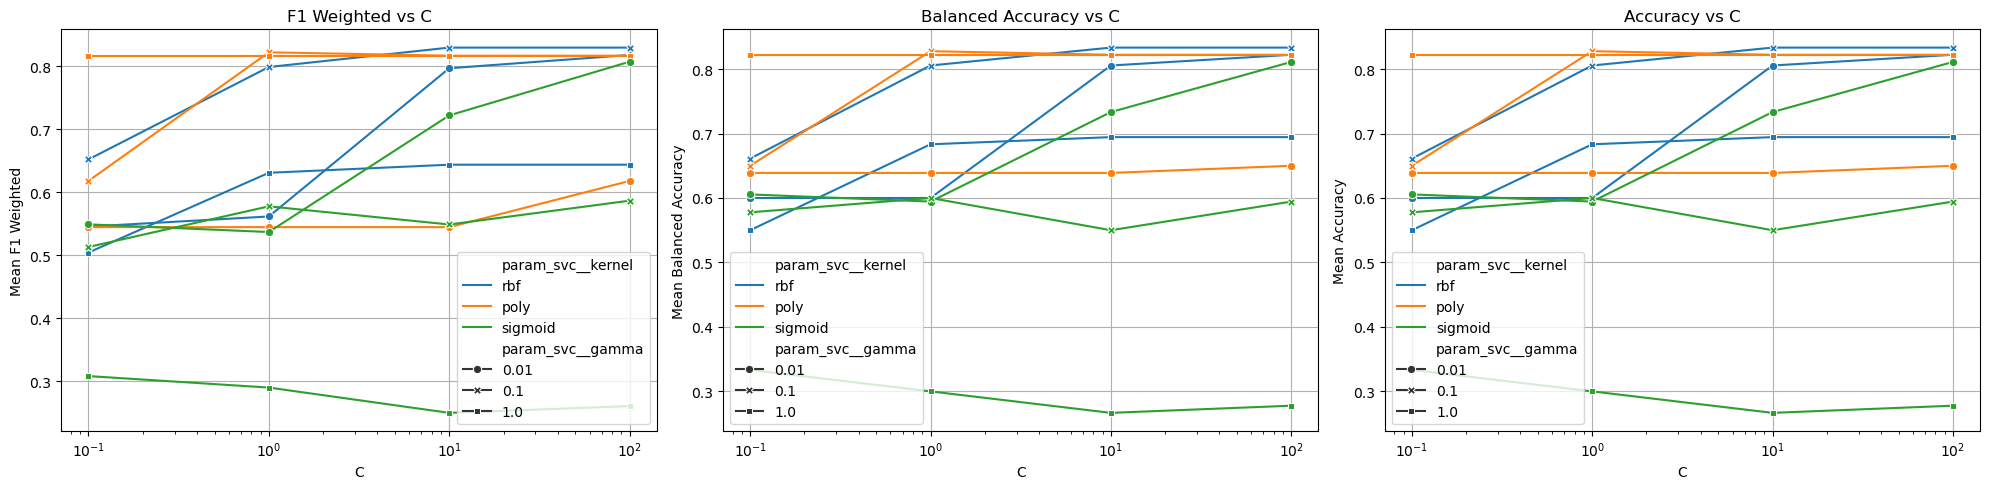

In [126]:
# Convert GridSearchCV results to DataFrame
results = pd.DataFrame(grid_search_svm.cv_results_)

# -----------------------------
# Lineplots: F1, Balanced Accuracy, Accuracy vs C
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 5))  # 1 row, 3 columns

# 1️⃣ F1 Weighted vs C
sns.lineplot(
    data=results,
    x='param_svc__C',
    y='mean_test_f1_weighted',
    hue='param_svc__kernel',
    style='param_svc__gamma',
    markers=True,
    dashes=False,
    ax=axes[0]
)
axes[0].set_xscale('log')
axes[0].set_xlabel('C')
axes[0].set_ylabel('Mean F1 Weighted')
axes[0].set_title('F1 Weighted vs C')
axes[0].grid(True)

# 2️⃣ Balanced Accuracy vs C
sns.lineplot(
    data=results,
    x='param_svc__C',
    y='mean_test_balanced_accuracy',
    hue='param_svc__kernel',
    style='param_svc__gamma',
    markers=True,
    dashes=False,
    ax=axes[1]
)
axes[1].set_xscale('log')
axes[1].set_xlabel('C')
axes[1].set_ylabel('Mean Balanced Accuracy')
axes[1].set_title('Balanced Accuracy vs C')
axes[1].grid(True)

# 3️⃣ Accuracy vs C
sns.lineplot(
    data=results,
    x='param_svc__C',
    y='mean_test_accuracy',
    hue='param_svc__kernel',
    style='param_svc__gamma',
    markers=True,
    dashes=False,
    ax=axes[2]
)
axes[2].set_xscale('log')
axes[2].set_xlabel('C')
axes[2].set_ylabel('Mean Accuracy')
axes[2].set_title('Accuracy vs C')
axes[2].grid(True)

# Adjust layout for the lineplots
plt.tight_layout()
plt.show()

In [127]:
dict_weights = {'death': 2, 'minor': 1, 'severe': 2}

#best hyperparameters
best_svm_tuned = Pipeline([
    ("preprocessor", preprocessor),
    ("svc", SVC(
        C=10,               # best C from grid search
        gamma=0.1,          # best gamma from grid search
        kernel='rbf',       # best kernel from grid search
        class_weight=dict_weights,  # apply weights to classes
        probability=True,   # to allow predict_proba
        random_state=42
    ))
])
# Train the model on the training data 
best_svm_tuned.fit(X_train, y_train)

# Make predictions on the test set
y_pred_tuned = best_svm_tuned.predict(X_test)
y_tuned_score = best_svm_tuned.predict_proba(X_test)  # probabilities for ROC/AUC

# Calculate metrics on the test set
f1_scores_test = f1_score(y_test, y_pred_tuned, average='weighted')
bal_accuracy_test = balanced_accuracy_score(y_test, y_pred_tuned)
accuracy_test = accuracy_score(y_test, y_pred_tuned)

print(f"Tuned SVM Test Set F1 Weighted: {f1_scores_test:.2f}")
print(f"Tuned SVM Test Set Balanced Accuracy: {bal_accuracy_test:.2f}")
print(f"Tuned SVM Test Set Accuracy: {accuracy_test:.2f}")

Tuned SVM Test Set F1 Weighted: 0.65
Tuned SVM Test Set Balanced Accuracy: 0.56
Tuned SVM Test Set Accuracy: 0.66


In [128]:
labels = ["death", "minor", "severe"]

y_pred = best_svm_tuned.predict(X_test)

#printing classification report
print("\nClassification Report (Test Set):\n")
print(classification_report(y_pred_tuned, y_test, labels=labels))
#precision, recall and f1 score are the lowest for those accidents whose injury_severity = death


Classification Report (Test Set):

              precision    recall  f1-score   support

       death       0.12      0.17      0.14         6
       minor       0.89      0.84      0.86        19
      severe       0.67      0.64      0.65        22

    accuracy                           0.66        47
   macro avg       0.56      0.55      0.55        47
weighted avg       0.69      0.66      0.67        47



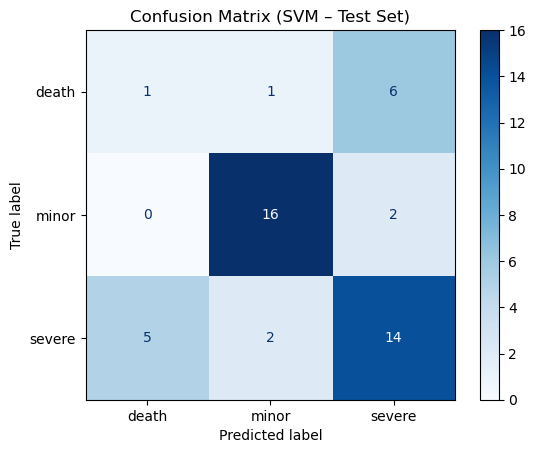

In [129]:
cm = confusion_matrix(y_test, y_pred_tuned, labels=labels)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=labels
)

disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (SVM – Test Set)")
plt.show()

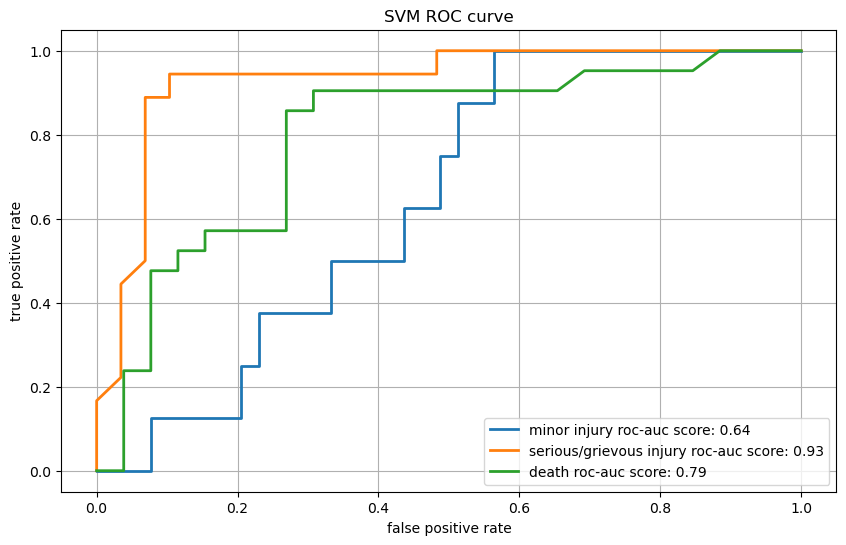

In [130]:
fpr = dict() #false positives
tpr = dict() #true positives
SVM_roc_auc = dict() #roc_auc_score
classes = ['death', 'minor', 'severe']
n_classes = len(classes)
y_test_bin = label_binarize(y_test, classes=classes)
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i],
                                  y_tuned_score[:, i])
    SVM_roc_auc[i] = roc_auc_score(y_test_bin[:, i],
                                  y_tuned_score[:, i])

    
    plt.plot(fpr[i], tpr[i], lw=2, label='class {}'.format(i))

plt.xlabel("false positive rate")
plt.ylabel("true positive rate")

label1 = (f"minor injury roc-auc score: {SVM_roc_auc[0]:.2f}")
label2 = (f"serious/grievous injury roc-auc score: {SVM_roc_auc[1]:.2f}")
label3 = (f"death roc-auc score: {SVM_roc_auc[2]:.2f}")
plt.legend(labels = [label1, label2, label3],loc="best")
plt.title("SVM ROC curve")
plt.grid(True)
plt.show()

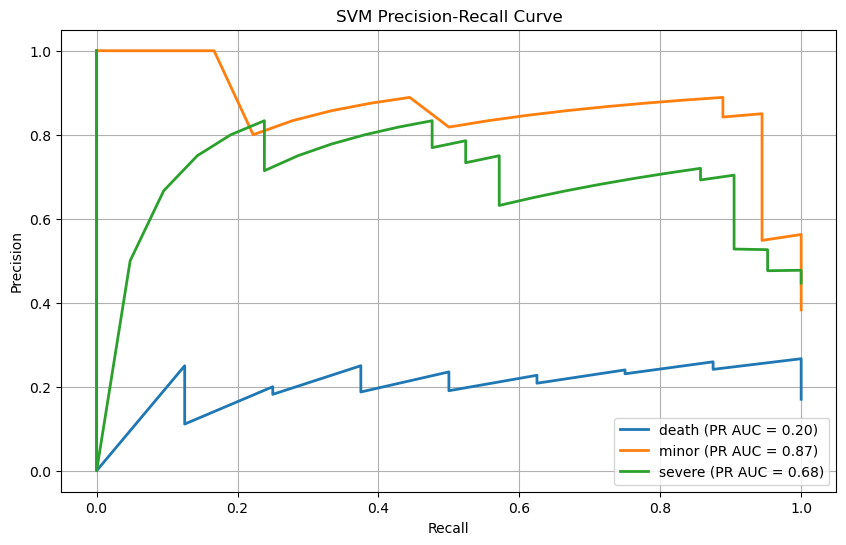

In [131]:
classes = ['death', 'minor', 'severe']  # your class names
n_classes = len(classes)

# Binarize test labels
y_test_bin = label_binarize(y_test, classes=classes)

# Get predicted probabilities from your tuned SVM
y_score = best_svm_tuned.predict_proba(X_test)

precision = dict()
recall = dict()
pr_auc_score = dict()

# Generate Precision-Recall curve
plt.figure(figsize=(10, 6))
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_bin[:, i], y_score[:, i])
    pr_auc_score[i] = auc(recall[i], precision[i])
    plt.plot(recall[i], precision[i], lw=2, label=f'{classes[i]} (PR AUC = {pr_auc_score[i]:.2f})')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("SVM Precision-Recall Curve")
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [132]:
# 1️⃣ Transform the test data using the preprocessor
X_test_transformed = best_svm_tuned.named_steps["preprocessor"].transform(X_test)

# Convert sparse matrix to dense if needed
if hasattr(X_test_transformed, "toarray"):
    X_test_transformed = X_test_transformed.toarray()

# 2️⃣ Compute permutation importance on the SVM model
result = permutation_importance(
    best_svm_tuned.named_steps["svc"],  # the trained SVM inside the pipeline
    X_test_transformed,
    y_test,
    n_repeats=30,
    random_state=42,
    n_jobs=-1
)

# 3️⃣ Get feature names after preprocessing
num_features_flat = best_svm_tuned.named_steps["preprocessor"] \
    .named_transformers_["num"] \
    .get_feature_names_out(numeric_features)

cat_features_flat = best_svm_tuned.named_steps["preprocessor"] \
    .named_transformers_["cat"] \
    .named_steps["onehot"] \
    .get_feature_names_out(categorical_features)

feature_names = np.concatenate([num_features_flat, cat_features_flat])

# 4️⃣ Create a DataFrame like your RF version
perm_imp_df = pd.DataFrame({
    "Feature": feature_names,
    "Permutation Importance": result.importances_mean
}).sort_values("Permutation Importance", ascending=False)

# 5️⃣ Display top features
perm_imp_df.head(10)

,Feature,Permutation Importance
2,vehicle_type_score,0.147518
4,time_period_Afternoon,0.014894
28,affected_party_driver,0.013475
6,time_period_Morning,0.009929
15,day_of_week_num_3,0.005674
1,driver_age_min,0.005674
8,primary_accident_type_code_COLL,0.002837
10,primary_accident_type_code_OTH,0.002128
130,street_Vjal L-Istadium Nazzjonali in Ta’ Qali,0.000000
120,street_Triq il-Ġermanja,0.000000


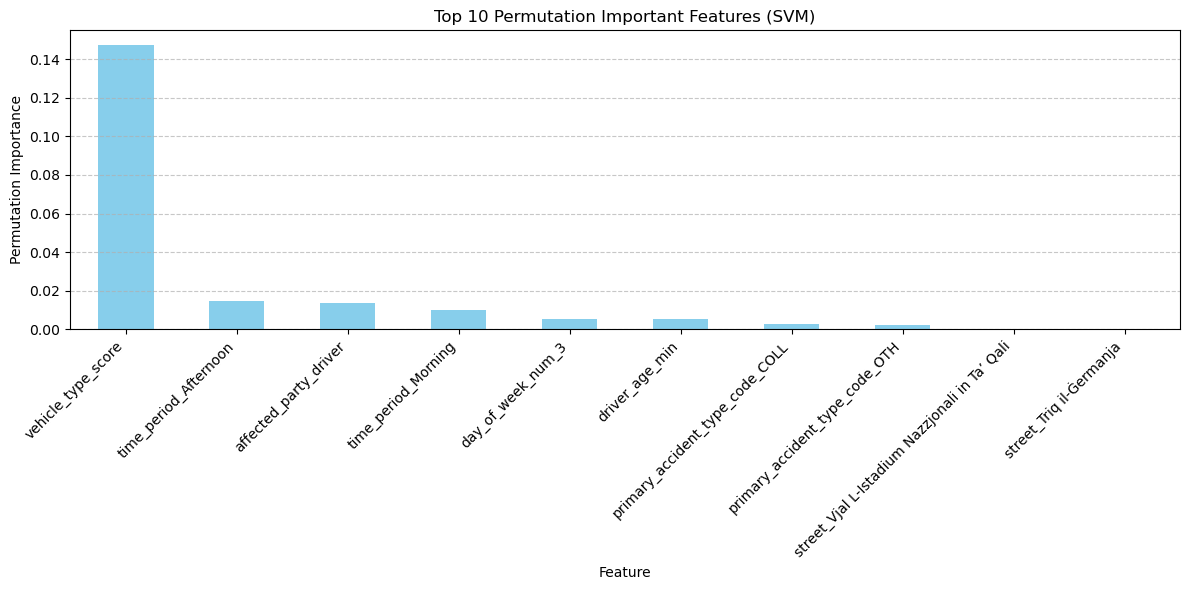

In [133]:
# Plot top 10 permutation important features as vertical bars
ax = perm_imp_df.head(10).plot(
    x="Feature",
    y="Permutation Importance",
    kind="bar",
    legend=False,
    figsize=(12,6),
    color='skyblue'
)

plt.title("Top 10 Permutation Important Features (SVM)")
plt.ylabel("Permutation Importance")
plt.xlabel("Feature")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()